### Notebook to visualise the class latent space of the model

In [1]:
import torch
import numpy as np
import scipy.stats as stats
import numpy.typing as npt
from numba import jit

# May need run this to change dir to the root of the project
import os
os.chdir('../../../')

from experiments.vae.vae import VAE, VAEConfig, set_seeds, RESOURCES

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as ani
from joblib import Parallel, delayed
from matplotlib.collections import PathCollection
import seaborn as sns

plt.rcParams['text.usetex'] = False

%matplotlib widget

[experiments.base] [INFO] Added console handler
[experiments.base] [INFO] Resources path: /home/akashg/git/NNs-and-Deep-Learning/experiments/../resources
[experiments.base] [INFO] Torch device: cpu


In [2]:
# Path to the model latents at each epoch

model_name = "20240830-194511l2_e1"
model_name = "20240830-221914l2_e1+b10"

save_path = RESOURCES / "models" / "vae" / model_name / "z_dist"

assert save_path.exists()

In [3]:
NUM_DIGITS = 10

In [4]:
# Load labels
labels = torch.load(next(save_path.glob("*labels*")))
labels = np.array(labels)
print("labels shape", labels.shape)

# Iterate over all files and load the latent loc and cov
torch_load_cpu = lambda f: torch.load(f, map_location='cpu')
z_mu_list = Parallel(n_jobs=8)(delayed(torch_load_cpu)(f) for f in save_path.glob("*z_mu*"))
print("num of training steps recorded", len(z_mu_list))
print("Shape of digit 0 latents in each step", z_mu_list[0][labels == 0].shape)

z_cov_list = Parallel(n_jobs=8)(delayed(torch_load_cpu)(f) for f in save_path.glob("*z_cov*"))
print("num of training steps recorded", len(z_cov_list))
print("Shape of digit 0 latents in each step", z_cov_list[0][labels == 0].shape)

labels shape (10000,)
num of training steps recorded 391
Shape of digit 0 latents in each step torch.Size([980, 2])
num of training steps recorded 391
Shape of digit 0 latents in each step torch.Size([980, 2, 2])


In [5]:
# digits x steps x samples x latent_dim
digit_z_mus = [np.stack([z_mu[labels == digit] for z_mu in z_mu_list]) for digit in range(NUM_DIGITS)]
len(digit_z_mus), [len(digit_z_mu) for digit_z_mu in digit_z_mus], digit_z_mus[0].shape

(10, [391, 391, 391, 391, 391, 391, 391, 391, 391, 391], (391, 980, 2))

In [6]:
# digits x steps x samples x latent_dim x latent_dim
digit_z_covs = [np.stack([z_cov[labels == digit] for z_cov in z_cov_list]) for digit in range(NUM_DIGITS)]
len(digit_z_covs), [len(digit_z_cov) for digit_z_cov in digit_z_covs], digit_z_covs[0].shape

(10, [391, 391, 391, 391, 391, 391, 391, 391, 391, 391], (391, 980, 2, 2))

In [7]:
def batched_normal_density(
    x: npt.NDArray[np.float_],
    mu: npt.NDArray[np.float_],
    cov: npt.NDArray[np.float_],
    log=False,
):
    """Return probability densities of batch[normal dists] at batch[x]

    x: n x dim
    mu: k x dim
    cov: k x dim x dim
    
    Z = sqrt((2 * pi) ^ dim * det(cov))
    e = exp(-0.5 * (x - mu)^T * cov^-1 * (x - mu))

    p(x) = e / Z [n x k]
    """
    
    # add axis for k dimension in mu
    x = x[:, None, :] # n x dim -> n x 1 x dim
    x = x - mu
    dim = mu.shape[-1]
    cov_inv = np.linalg.inv(cov)

    if log:
        log_Z = 0.5 * dim * np.log(2 * np.pi) + 0.5 * np.linalg.slogdet(cov)[1]
        e = -0.5 * np.einsum("...i,...ij,...j->...", x, cov_inv, x)
        return e - log_Z

    Z = np.sqrt((2 * np.pi) ** dim * np.linalg.det(cov))
    e = np.exp(-0.5 * x[:, :, None, :] @ cov_inv @ x[:, :, :, None])

    return e.squeeze() / Z

digit, timestep = 0, 100
z_mus = digit_z_mus[digit][timestep]
z_covs = digit_z_covs[digit][timestep]

x, y = np.mgrid[-3:3:0.1, -3:3:0.1]
pos = np.dstack((x, y))
pos_flat = pos.reshape(-1, 2)

pdfsT = batched_normal_density(pos_flat, z_mus, z_covs)

In [8]:
def mog_mean_cov(mus, covs):
	"""Return the mean and covariance for a _mixture_ of gaussians
	
	mus: k x dim
	cov: k x dim x dim
	"""

	# Mean
	mean = np.mean(mus, axis=0) # dim

	# Covariance
	avg_cov = np.mean(covs, axis=0) # dim x dim
	avg_sq_mean = np.mean(mus[:, :, None] @ mus[:, None, :], axis=0) # dim x dim
	avg_mean_sq = np.outer(mean, mean) # dim x dim

	cov = avg_cov + avg_sq_mean - avg_mean_sq

	return mean, cov

mean, cov = mog_mean_cov(z_mus, z_covs)
mean.shape, cov.shape, mean, cov

((2,),
 (2, 2),
 array([1.5751408 , 0.13726424], dtype=float32),
 array([[0.7092285 , 0.03225531],
        [0.03225531, 1.118363  ]], dtype=float32))

Updating  328


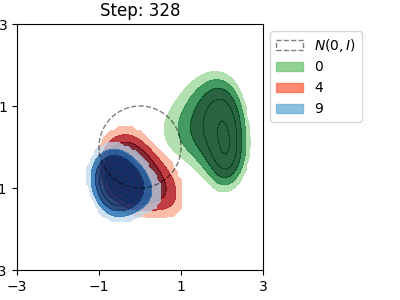

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.set_aspect("equal")

LIMS = (-3, 3)

ax.set_xlim(*LIMS)
ax.set_ylim(*LIMS)

x, y = np.mgrid[-3:3:0.1, -3:3:0.1]
pos = np.dstack((x, y))
pos_flat = pos.reshape(-1, 2)

digits = [0, 4, 9]

levels = 2

# threshold pdfs to 0 if less than this value
THRESH = stats.multivariate_normal.pdf((0, 1), np.zeros(2), np.eye(2))
# print("THRESH", THRESH)

cmaps = [mpl.cm.Greens, mpl.cm.Reds, mpl.cm.Blues]

def gaussian_ellipse(ax, mean=(0, 0), cov1=1, cov2=1, label=r"$N(0, I)$"):
    # plot std_normal as an ellipse using patches.Ellipse
    e = mpl.patches.Ellipse(
        mean,
        2*cov1,  # width = 2 std
        2*cov2,  # height = 2 std
        fill=False,
        edgecolor="black",
        linestyle="dashed",
        label=label,
        alpha=0.5,
    )
    return e

def thresh_colormap(cmap, thresh):
    transparent = (1, 1, 1, 0)
    newcmp = np.vstack((transparent, cmap(np.arange(cmap.N))))
    # Add transluceny to the colormap
    newcmp[:, -1] = np.sqrt(np.linspace(0.5, 0.7, cmap.N + 1))
    newcmp[0, -1] = 0 # set the first color to be fully transparent
    newcmp = mpl.colors.ListedColormap(newcmp)

    # upper = 0.5 * (thresh + np.max(pdfs))
    upper = 2 * thresh
    norm = [0, thresh] + list(np.linspace(thresh, upper, cmap.N))
    norm = mpl.colors.BoundaryNorm(norm, newcmp.N)

    return newcmp, norm

def plot_digit_dist(digit: int, timestep: int, cmap=None, norm=None, idx=0):
    z_mus = digit_z_mus[digit][timestep]
    z_covs = digit_z_covs[digit][timestep]

    # plot mean and covariance as ellipse
    mean, cov = mog_mean_cov(z_mus, z_covs)
    cov1, cov2 = np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1])
    # e = gaussian_ellipse(ax, mean, cov1, cov2, label=rf"$N_{digit}$")
    # ax.add_patch(e)

    pdfs = batched_normal_density(pos_flat, z_mus, z_covs)
    pdfs = pdfs.mean(axis=1).reshape(*pos.shape[:2])

    # threshold pdfs to 0 if less than 1 std away from the mean
    THRESH = stats.multivariate_normal.pdf(mean + np.array([cov1, cov2]), mean, cov)
    cmap, norm = thresh_colormap(cmap, THRESH)
    # print("THRESH", THRESH)

    # threshold pdfs to 0
    pdfs[pdfs < THRESH] = 0

    cs = ax.contourf(
        x,
        y,
        pdfs,
        # levels,
        # alpha=0.1,
        cmap=cmap,
        norm=norm,
    )




def update(timestep: int):
    print("Updating ", timestep)
    ax.clear()
    ax.set_aspect("equal")

    ax.set_title(f"Step: {timestep:03d}")

    ax.set_xlim(*LIMS)
    ax.set_ylim(*LIMS)

    for idx, digit in enumerate(digits):
        cmap = cmaps[idx]
        # newcmp, norm = thresh_colormap(cmap, THRESH)
        plot_digit_dist(digit, timestep, cmap, None, idx)
        # plot_digit_dist(digit, timestep, newcmp, norm, idx)

    # plot std_normal as an ellipse
    e = gaussian_ellipse(ax)
    ax.add_patch(e)

    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))

    # axis keep ticks [-1, 0, 1]
    ax.set_xticks(np.arange(-3, 4, 2))
    ax.set_yticks(np.arange(-3, 4, 2))
    # ax.grid(True)


# plot std_normal as an ellipse
e = gaussian_ellipse(ax)
ax.add_patch(e)

handles, labels = ax.get_legend_handles_labels()

timestep = 100
timestep = 328

for idx in range(len(digits)):
    newcmp, norm = thresh_colormap(cmaps[idx], THRESH)
    patch = mpl.patches.Patch(color=newcmp(norm(1.5*THRESH)))
    handles.append(patch)
    labels.append(rf"${digits[idx]}$")

update(timestep)

plt.subplots_adjust(left=-0.5, right=1.2, top=0.92, bottom=0.1, wspace=0., hspace=0.)

# plt.tight_layout()
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Updating  0
Updating  0
Updating  1
Updating  2
Updating  3
Updating  4
Updating  5
Updating  6
Updating  7
Updating  8
Updating  9
Updating  10
Updating  11
Updating  12
Updating  13
Updating  14
Updating  15
Updating  16
Updating  17
Updating  18
Updating  19
Updating  20
Updating  21
Updating  22
Updating  23
Updating  24
Updating  25
Updating  26
Updating  27
Updating  28
Updating  29
Updating  30
Updating  31
Updating  32
Updating  33
Updating  34
Updating  35
Updating  36
Updating  37
Updating  38
Updating  39
Updating  40
Updating  41
Updating  42
Updating  43
Updating  44
Updating  45
Updating  46
Updating  47
Updating  48
Updating  49
Updating  50
Updating  51
Updating  52
Updating  53
Updating  54
Updating  55
Updating  56
Updating  57
Updating  58
Updating  59
Updating  60
Updating  61
Updating  62
Updating  63
Updating  64
Updating  65
Updating  66
Updating  67
Updating  68
Updating  69
Updating  70
Updating  71
Updating  72
Updating  73
Updating  74
Updating  75
Updating  

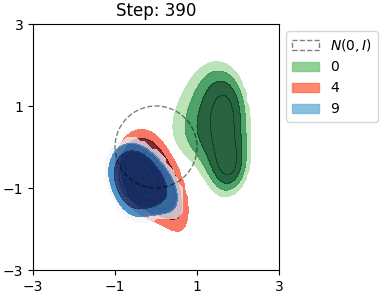

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3.9, 3))
plt.tight_layout()

plt.subplots_adjust(left=-0.5, right=1.3, top=0.92, bottom=0.1, wspace=0., hspace=0.)

# plot std_normal as an ellipse
e = gaussian_ellipse(ax)
ax.add_patch(e)

ani = mpl.animation.FuncAnimation(
    fig,
    update,
    # frames=1,
    frames=len(digit_z_mus[0]),
    interval=100,
)

ani.save(
    RESOURCES / f"../experiments/vae/vis/class_latents_{model_name}.gif",
    writer="imagemagick",
    fps=10,
)

plt.show()